# Bonus Tutorial: Autoencoder and Embeddings

<p>
Bern Winter School on Machine Learning, 2023<br>
Prepared by Mykhailo Vladymyrov and Matthew Vowels.
</p>

This work is licensed under a <a href="http://creativecommons.org/licenses/by-nc-sa/4.0/">Creative Commons Attribution-NonCommercial-ShareAlike 4.0 International License</a>.

In this session we will create a fully-connected autoencoder

## 1. Load necessary libraries



In [1]:
import os
import sys
import tarfile
import requests

import random
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
import torch.utils.data
from torch.utils.data import TensorDataset, DataLoader



# URL of the file to download
url = 'https://github.com/neworldemancer/BMLWS/raw/main/tut_files/tpub0320.tgz'

# Path where the file will be saved
path = os.path.abspath('.') + '/material.tgz'

# Download the file
response = requests.get(url)
assert response.status_code == 200, "Download failed"
with open(path, 'wb') as file:
    file.write(response.content)

# Check if the path is correct
assert os.path.exists(path), "File not found"

# Extract the tar file
tar = tarfile.open(path, "r:gz")
tar.extractall()
tar.close()

100%|██████████| 9912422/9912422 [00:00<00:00, 111246802.45it/s]


Extracting /root/.pytorch/MNIST_data/MNIST/raw/train-images-idx3-ubyte.gz to /root/.pytorch/MNIST_data/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 26948986.39it/s]


Extracting /root/.pytorch/MNIST_data/MNIST/raw/train-labels-idx1-ubyte.gz to /root/.pytorch/MNIST_data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 27614191.41it/s]


Extracting /root/.pytorch/MNIST_data/MNIST/raw/t10k-images-idx3-ubyte.gz to /root/.pytorch/MNIST_data/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 3573537.57it/s]


Extracting /root/.pytorch/MNIST_data/MNIST/raw/t10k-labels-idx1-ubyte.gz to /root/.pytorch/MNIST_data/MNIST/raw

Train dataset shape: 60000 total images and labels
Test dataset shape: 10000 total images and labels


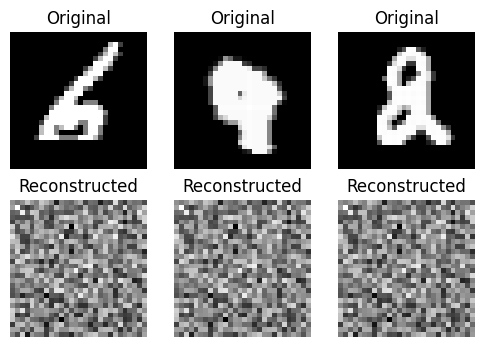

Epoch 1/5, Train Loss: 0.2684


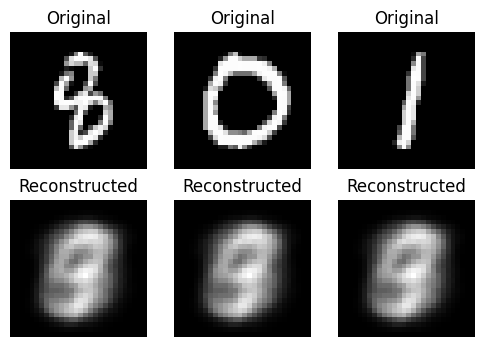

Epoch 2/5, Train Loss: 0.2562


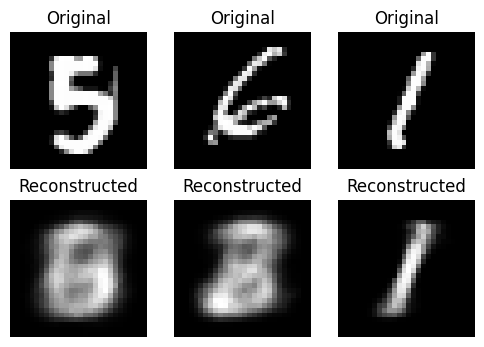

Epoch 3/5, Train Loss: 0.1507


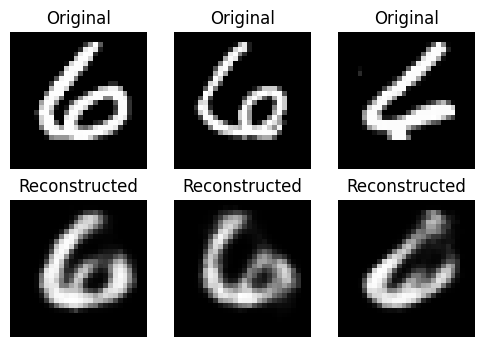

Epoch 4/5, Train Loss: 0.1146


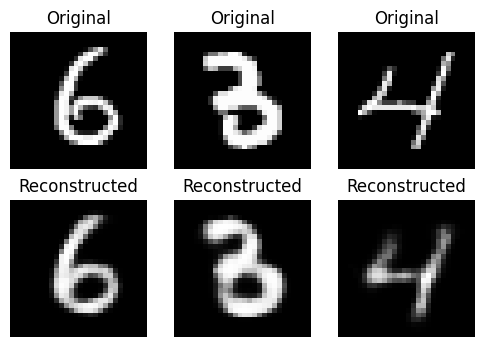

Epoch 5/5, Train Loss: 0.1023


In [2]:
transform = transforms.Compose([transforms.ToTensor(),  # Scales the pixel values to the range [0, 1]
    transforms.Lambda(lambda x: torch.flatten(x))])

# Download and load the training data
trainset = datasets.MNIST('~/.pytorch/MNIST_data/', download=True, train=True, transform=transform)
trainloader = DataLoader(trainset, batch_size=64, shuffle=True)

# Download and load the test data
testset = datasets.MNIST('~/.pytorch/MNIST_data/', download=True, train=False, transform=transform)
testloader = DataLoader(testset, batch_size=64, shuffle=True)

# Print shapes of the datasets
print('Train dataset shape:', len(trainset), 'total images and labels')
print('Test dataset shape:', len(testset), 'total images and labels')


class AutoEncoder(nn.Module):
    def __init__(self, n_input, n_hidden, latent_dim):
        super(AutoEncoder, self).__init__()
        self.encl1 = nn.Linear(n_input, n_hidden)
        self.encl2 = nn.Linear(n_hidden, n_hidden)
        self.encl4 = nn.Linear(n_hidden, latent_dim)

        self.decl1 = nn.Linear(latent_dim, n_hidden)
        self.decl2 = nn.Linear(n_hidden, n_hidden)
        self.decl4 = nn.Linear(n_hidden, n_input)

    def forward(self, x):
        enc = F.tanh(self.encl4(
                F.relu(self.encl2(
                    F.relu(self.encl1(x))))))

        dec = torch.sigmoid(self.decl4(
                F.relu(self.decl2(
                    F.relu(self.decl1(enc))))))

        return enc, dec


def train(model, trainloader, criterion, optimizer):
    model.train()
    running_loss = 0.0
    for i, (images, _) in enumerate(trainloader):
        optimizer.zero_grad()  # reset gradients
        encodings, decodings = model(images)
        loss = criterion(decodings, images)
        loss.backward()    # compute gradients
        optimizer.step()   # update parameters with gradients
        running_loss += loss.item()

        if i == 0:  # Visualize for the first batch of each epoch
            model.eval()
            with torch.no_grad():
              _, sample_decodings = model(images[:num_viz_images])
            visualize_reconstruction(images[:num_viz_images], sample_decodings)
            model.train()

    return running_loss / len(trainloader)


def visualize_reconstruction(original, reconstructed, num_images=5):
    # Check if there are enough images
    num_available = min(original.size(0), reconstructed.size(0), num_images)

    original = original.view(original.size(0), 28, 28)  # Reshape to 28x28 if needed
    reconstructed = reconstructed.view(reconstructed.size(0), 28, 28)

    fig, axes = plt.subplots(nrows=2, ncols=num_available, figsize=(2 * num_available, 4))
    for i in range(num_available):
        # Display original
        axes[0, i].imshow(original[i].cpu().numpy(), cmap='gray')
        axes[0, i].set_title("Original")
        axes[0, i].axis('off')

        # Display reconstruction
        axes[1, i].imshow(reconstructed[i].cpu().numpy(), cmap='gray')
        axes[1, i].set_title("Reconstructed")
        axes[1, i].axis('off')

    plt.show()



criterion = nn.BCELoss()

ae = AutoEncoder(n_input=784, n_hidden=256, latent_dim=64)

optimizer = optim.Adam(ae.parameters(), lr=1e-3)
num_viz_images = 3

num_epochs = 5
train_losses = []

for epoch in range(num_epochs):
    train_loss = train(model=ae, trainloader=trainloader, criterion=criterion, optimizer=optimizer)

    train_losses.append(train_loss)

    print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}')


## 5. Load the data

First we will load the data: 60000 training images and 10000 images for validation with some included data transformations.

Each image is a 28x28 pixels. For this model we will interpret it as a 1D array of 784 elements.

100%|██████████| 9912422/9912422 [00:00<00:00, 112254835.70it/s]


Extracting /root/.pytorch/MNIST_data/MNIST/raw/train-images-idx3-ubyte.gz to /root/.pytorch/MNIST_data/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 71298230.62it/s]


Extracting /root/.pytorch/MNIST_data/MNIST/raw/train-labels-idx1-ubyte.gz to /root/.pytorch/MNIST_data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 32213383.93it/s]


Extracting /root/.pytorch/MNIST_data/MNIST/raw/t10k-images-idx3-ubyte.gz to /root/.pytorch/MNIST_data/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 4844997.14it/s]


Extracting /root/.pytorch/MNIST_data/MNIST/raw/t10k-labels-idx1-ubyte.gz to /root/.pytorch/MNIST_data/MNIST/raw

Train dataset shape: 60000 total images and labels
Test dataset shape: 10000 total images and labels


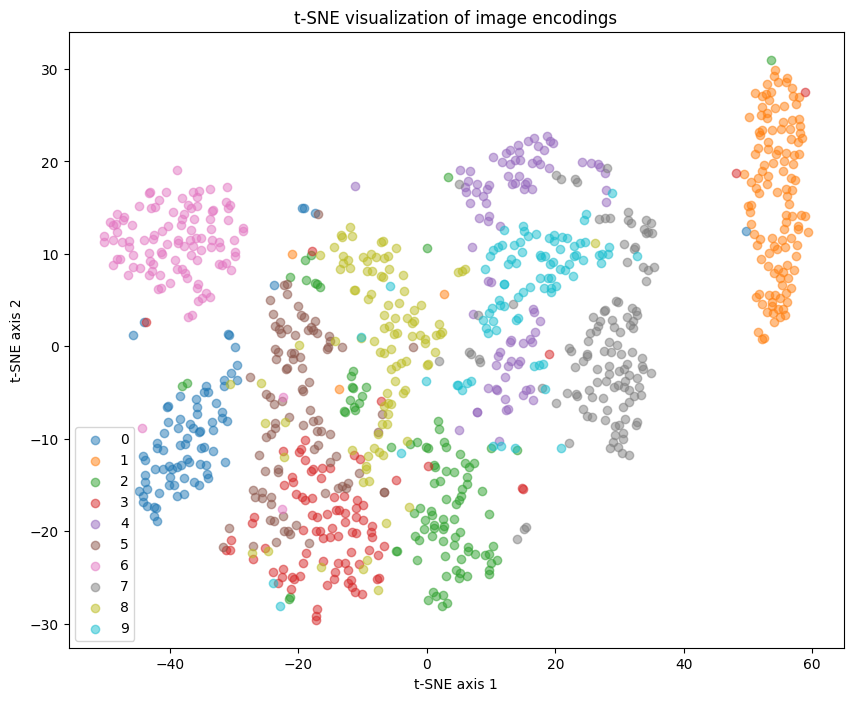

In [3]:
from sklearn.manifold import TSNE  # UMAP

def visualize_encodings(model, dataloader, num_samples=1000):
    model.eval()
    embeddings = []
    labels = []

    # Collect encodings and labels
    with torch.no_grad():
        for i, (images, label) in enumerate(trainloader):
            if len(embeddings) >= num_samples:
                break
            enc, _ = model(images)
            embeddings.append(enc)
            labels.append(label)

    # Convert lists to tensors
    embeddings = torch.cat(embeddings)[:num_samples]
    labels = torch.cat(labels)[:num_samples]

    # Run t-SNE
    tsne = TSNE(n_components=2, random_state=1)
    embeddings_2d = tsne.fit_transform(embeddings.cpu().numpy())

    # Plot
    plt.figure(figsize=(10, 8))
    for i in range(10):  # Assuming 10 classes (0-9) for MNIST
        indices = labels == i
        plt.scatter(embeddings_2d[indices, 0], embeddings_2d[indices, 1], label=str(i), alpha=0.5)
    plt.legend()
    plt.title("t-SNE visualization of image encodings")
    plt.xlabel("t-SNE axis 1")
    plt.ylabel("t-SNE axis 2")
    plt.show()

# Example usage
visualize_encodings(ae, trainloader)